Epoch 0: Training loss: 6619.20068359375, Validation loss: 9825.84375
Epoch 100: Training loss: 7.175497531890869, Validation loss: 10.81618595123291
Epoch 200: Training loss: 6.983817100524902, Validation loss: 5.643347263336182
Epoch 300: Training loss: 3.2453458309173584, Validation loss: 5.632359027862549
Epoch 400: Training loss: 3.2136361598968506, Validation loss: 5.802889823913574
Epoch 500: Training loss: 3.109998941421509, Validation loss: 4.496435165405273
Epoch 600: Training loss: 2.470777988433838, Validation loss: 3.219796895980835
Epoch 700: Training loss: 3.512402296066284, Validation loss: 3.5055644512176514
Epoch 800: Training loss: 4.226925373077393, Validation loss: 4.470743179321289
Epoch 900: Training loss: 3.916107416152954, Validation loss: 5.032033920288086
Test loss: 6.227309703826904


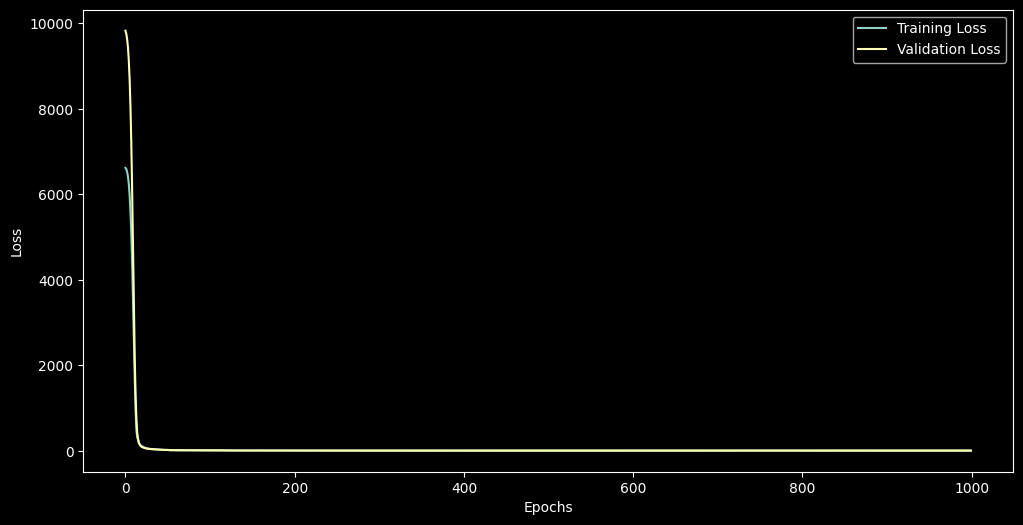

In [2]:
import tensorflow as tf
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
X, y = make_regression(n_samples=1000, n_features=5, noise=0.1)
y = y.reshape(-1, 1)  # Reshape y to be a column vector

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(5,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Custom SGD optimizer with gradient clipping
class CustomSGD:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            clipped_grad = tf.clip_by_value(grad, -1.0, 1.0)
            var.assign_sub(self.learning_rate * clipped_grad)

# Loss function
loss_fn = tf.keras.losses.MeanSquaredError()

# Training loop
def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, optimizer):
    train_loss_results = []
    val_loss_results = []

    for epoch in range(epochs):
        # Training
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            with tf.GradientTape() as tape:
                predictions = model(X_batch, training=True)
                loss = loss_fn(y_batch, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Validation
        val_predictions = model(X_val, training=False)
        val_loss = loss_fn(y_val, val_predictions)

        train_loss_results.append(loss.numpy())
        val_loss_results.append(val_loss.numpy())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Training loss: {loss.numpy()}, Validation loss: {val_loss.numpy()}")

    return train_loss_results, val_loss_results

# Initialize the custom optimizer
optimizer = CustomSGD(learning_rate=0.001)

# Train the model
train_loss, val_loss = train(model, X_train, y_train, X_val, y_val, epochs=1000, batch_size=32, optimizer=optimizer)

# Evaluate on test set
test_predictions = model(X_test, training=False)
test_loss = loss_fn(y_test, test_predictions).numpy()
print(f"Test loss: {test_loss}")

# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()